In [1]:
import numpy as np
import hera_pspec as hp
import healpy as hlp
from pyuvdata import UVData
import copy, os, itertools, inspect
import matplotlib.pyplot as plt
from hera_pspec.data import DATA_PATH
import scipy.integrate as integrate
import itertools  
from scipy.stats import multivariate_normal
import astropy.units as u

In [2]:
def get_bsl_vector(baseline):
    antpos = uvd.antenna_positions
    ant1 = np.argwhere(uvd.antenna_numbers==baseline[0])[0][0]
    ant2 = np.argwhere(uvd.antenna_numbers==baseline[1])[0][0]
    bl_vec = antpos[ant1] - antpos[ant2]
    print("baseline vector : ",bl_vec,"separation distance : ",np.sqrt(bl_vec[0]**2+bl_vec[1]**2))
    return bl_vec

In [3]:
# This function was taken from aipy and it involves creating the rotation matrix
# that will be multiplied by the baseline vector to know the baseline as a function of time
def rot_m(ang, vec):
    """Return 3x3 matrix defined by rotation by 'ang' around the
    axis 'vec', according to the right-hand rule.  Both can be vectors,
    returning a vector of rotation matrices.  Rotation matrix will have a
    scaling of |vec| (i.e. normalize |vec|=1 for a pure rotation)."""
    c = np.cos(ang); s = np.sin(ang); C = 1-c
    x,y,z = vec[...,0], vec[...,1], vec[...,2]
    xs,ys,zs = x*s, y*s, z*s
    xC,yC,zC = x*C, y*C, z*C
    xyC,yzC,zxC = x*yC, y*zC, z*xC
    rm = np.array([[x*xC+c, xyC-zs, zxC+ys],
                   [xyC+zs, y*yC+c, yzC-xs],
                   [zxC-ys, yzC+xs, z*zC+c]], dtype=np.double)
    if rm.ndim > 2:
        axes = list(range(rm.ndim))
        return rm.transpose(axes[-1:] + axes[:-1])
    else:
        return rm

In [4]:
# This function was taken from Bobby Pascua and it calculates the baseline vector over time.
# It returns a list of the baseline vector at each time sample.
def get_bl_over_time(baseline):
    # get baselines
    bls = uvd.get_antpairs()
    # get baseline vector
    bl_vec = get_bsl_vector(baseline)
    # get time offset between visibilities in seconds
    dt = np.diff(np.unique(uvd.time_array)).mean()*u.day.to('s')
    print("Time offset : ",dt)
    # get the number of time steps
    Ntimes = len(np.unique(uvd.time_array)[:-1:2])
    
    print("Number of time steps : ",Ntimes)
    # get Earth's rotational angular frequency
    omega = 2*np.pi/u.sday.to('s')  # rad/s
    print("Earth's rotational angular frequency : ",omega)

    # get lat, lon, alt for HERA
    lat, lon, alt = uvd.telescope_location_lat_lon_alt
    colat = np.pi/2 - lat

    # define y and z basis vectors for generating rotation matrices
    yhat = np.array([0,1,0])
    zhat = np.array([0,0,1])

    # define rotation matrices for correctly calculating the beam position
    Ry = rot_m(-colat, yhat)
    Rz = rot_m(-lon, zhat)
    Ryz = np.dot(Ry, Rz)

    # define projection matrix
    Mproj = rot_m(omega*dt, zhat) - np.eye(3)

    rot_bl = []
    for j in range(Ntimes):

        # calculate the phase by which the baselines and beam have been rotated
        # due to Earth rotation
        tot_phase = j * omega * dt

        # define rotation matrix for Earth rotation
        Rt = rot_m(tot_phase, zhat)

        # get the rotated baseline
        rot_bl.append(np.dot(Rt, bl_vec))

    rot_bl = np.array(rot_bl)
    return rot_bl

In [61]:
def gaussian_window_function(k_vec,b_vec,tau,sigmar,sigmamu,muo,Dc,Dco,aplha):
    kx = k_vec[:,0]
    ky = k_vec[:,1]
    kz = k_vec[:,2]
    #kx=k_vec[0]
    #ky=k_vec[1]
    #kz=k_vec[2]
    bx = b_vec[0]
    by = b_vec[1]
    bz = b_vec[2]
    c = 3*10**8
    
    kzexp = np.exp(1j*kz*(alpha*muo+Dco))
    muoexp = np.exp(-muo**2/(2*sigmamu**2))
    kxkyexp = np.exp(-sigmar**2*Dc**2*(kx**2+ky**2)/2)
    A=(4*np.pi**2*sigmar**2*(bx**2+by**2)/c**2)+1/(sigmamu**2)
    B=(4*np.pi*Dc*sigmar**2*(bx*kx+by*ky)/(2*c) + muo/sigmamu**2 - 1j*(2*np.pi*tau+alpha*kz))
    exponent=np.exp(B**2/(2*A))
    #exponent_denominator = ((2*sigma_r**2)*(4*np.pi**2*sigma_r**2*sigma_mu**2*(bx**2+by**2)+c**2))
    #print(exponent/exponent_denominator)
    #norm_factor = sigma_r/(sigma_mu*np.sqrt(((2*np.pi*sigma_r**2*(bx**2+by**2))/c**2)+1/(2*np.pi*sigma_mu**2)))
    #print(1j*kz*(alpha*muo+Dco))
    #print(-sigmar**2*Dc**2*(kx**2+ky**2)/2) #DC blows up this exponential
    #print(norm_factor)
    #print(B**2/(2*A))
    #print(1j*kz*(alpha*muo+Dco))
    #print(-muo**2/(2*sigmamu**2))
    #print(-sigmar**2*Dc**2*(kx**2+ky**2)/2)
    #print(B**2/(2*A))
    
    #print(kzexp)
    #print(muoexp)
    #print(kxkyexp)
    #print(exponent)
    #print(B)
    #print(A)
    window_function = np.sqrt(2*np.pi/A)*sigmar/sigmamu * np.multiply(np.exp(exponent),np.conjugate(np.exp(exponent)))
    #norm_factor=np.sum(window_function.flatten())
    #print(window_function)
    return window_function

In [6]:
# Load in the data
dfile = os.path.join(DATA_PATH, 'zen.2458116.38650.xx.HH.uvOCRS')
# Load into UVData objects
uvd = UVData()
data= uvd.read(dfile)

In [7]:
# Here we get the baseline vector over time.
# set baseline = (136,143) or baseline = (136,137)
baseline = (136,143)
rot_bl = get_bl_over_time(baseline)

baseline vector :  [ 37.25842663 -95.22542592  -0.39103548] separation distance :  102.25493678552957
Time offset :  10.737418446500424
Number of time steps :  30
Earth's rotational angular frequency :  7.292115855377074e-05


In [8]:
cosmo = hp.conversions.Cosmo_Conversions()

In [52]:
# We must calculate at which k_parr and k_perp the window function will peak.
# This is necessary to have a rough idea of what range of other k vec values
# we need to see see power leakage.

# We set the delay tau at which our window function will use.
tau = 10*10**(-9)
# To find the redshift z, we will use the average frequency at which we are using
mu_array = np.linspace(150*10**6,170*10**6,100)
average_mu = np.mean(mu_array)
red_shift = cosmo.f2z(freq=average_mu)
# The next two lines are conversion factors to go from b to k_perp or tau to k_parr
k_perp_conversion_factor = cosmo.bl_to_kperp(red_shift)
k_parr_conversion_factor = cosmo.tau_to_kpara(red_shift)
peak_k_parr = k_parr_conversion_factor*tau
# rot_bl contains a baseline as a function of time. As earth rotates, the baselines orientation changes
# making it probe different uv modes. However, the length of the baseline doesn't change
# and for this conversion factor we must use the length of the baseline. So a baseline vector
# from any time sample will do.
peak_k_perp = k_perp_conversion_factor*rot_bl[20,:2]
print(peak_k_parr)
print(peak_k_perp)

sigma_mu = np.std(mu_array)
print(sigma_mu)
sigma_r = np.std(np.linspace(-1,1,100))
D_c = z = cosmo.DC(cosmo.f2z(average_mu))
Dco=D_c
alpha=0.01

0.005605344291045071
[ 0.02114732 -0.05164997]
5831529.302570124


In [10]:
array_stack = lambda a, n : [i for i in a for j in range(n)]

In [57]:
# With eq.39 from Adrian's recent paper, we can know at which delay value tau the window function
# will peak along the k_parr axis. We also know for which baseline vector b our window function 
# will peak along the k_perp axis. We want to create k_perp and k_parr values around these peaks.
k_1d_y = np.array(np.linspace(-1+peak_k_perp[1],peak_k_perp[1]+1,200))
k_1d_x = np.array(np.linspace(-1+peak_k_perp[0],peak_k_perp[0]+1,200))
k_1d_parr = np.array(np.linspace(peak_k_parr-1,peak_k_parr+1,200))

k_1d_perp_vec = np.stack((k_1d_x,k_1d_y),axis=1)
kperp_stacked = np.tile(k_1d_perp_vec,(k_1d_perp_vec.shape[0],1))
kparr_stacked = array_stack(k_1d_parr,k_1d_parr.shape[0])
k_1d = np.column_stack((kperp_stacked,kparr_stacked))

In [18]:
print(tau,sigma_r,sigma_mu,average_mu,D_c,alpha,Dco)

1e-08 0.5831529302570125 5831529.302570124 159999999.99999997 6134.965025383039 0.01 6134.965025383039


In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
#Calculate a peaking Kperp and kparr
tau=1
sigma_r=1
sigma_mu=1
average_mu=1
D_c=1
Dco=1
alpha=1
wf = gaussian_window_function(k_1d,rot_bl,tau,sigma_r,sigma_mu,average_mu,D_c,Dco,alpha)


In [62]:
# For each baseline vector, we calculate the g function matrix and then compute the window function.
i=0

for b_vec in rot_bl:
    wf = gaussian_window_function(k_1d,b_vec,tau,sigma_r,sigma_mu,average_mu,D_c,Dco,alpha)
    
    if i == 0:
        N = int(len(wf)**.5)
        z= np.transpose(wf.reshape(N, N))
    else:
        N = int(len(wf)**.5)
        z_new= np.transpose(wf.reshape(N, N))
        z = np.dstack((z,z_new))
    i=i+1

<IPython.core.display.Javascript object>


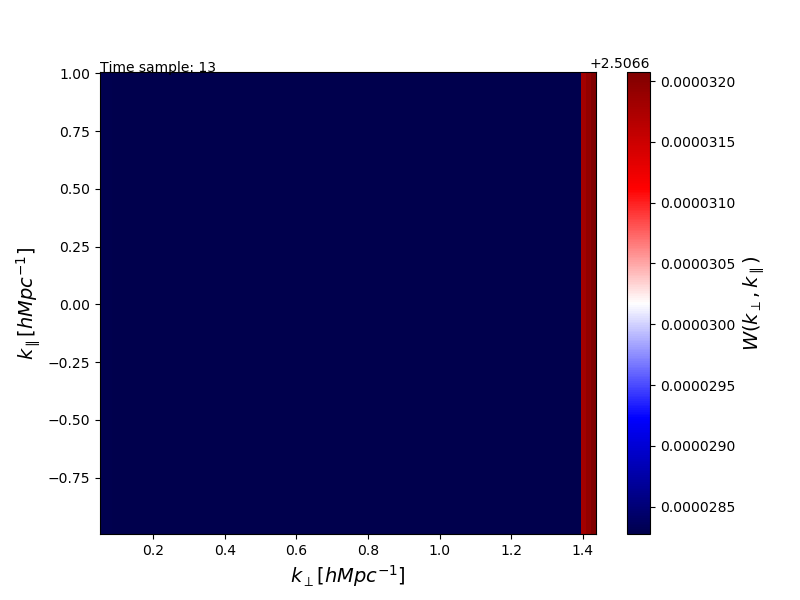

In [63]:
#Get the animated window function over all time samples.
%matplotlib nbagg
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.pcolormesh(np.linalg.norm(k_1d_perp_vec,axis=1),k_1d_parr,np.real(z[:-1, :-1, 0]), cmap='seismic')
time_text = plt.text(0, 1, 'Time sample: {}'.format(0), fontsize=10,transform=ax.transAxes) 

cb = fig.colorbar(cax)
cb.set_label(r"$W(k_\perp,k_\parallel)$",fontsize=14)
ax.set_xlabel(r"$k_\perp [h Mpc^{-1}]$",fontsize=14)
ax.set_ylabel(r"$k_\parallel [h Mpc^{-1}]$",fontsize=14)

def animate(i):
      
    cax.set_array(np.real(z[:-1, :-1, i]).flatten())
    time_text.set_text('Time sample: {}'.format(i)) 
    
anim = FuncAnimation(fig, animate, interval=100, frames=30, repeat=True,blit=False)

plt.show()
#print(k_1d_y[np.where(wf==np.max(wf))[0][0]],k_1d_x[np.where(wf==np.max(wf))[0][0]])
#plt.savefig("GaussianWindowFunction.png",dpi=250)

In [ ]:
#Average window function
%matplotlib inline
plt.plot(wf)
plt.show()

In [ ]:
#Get the animated window function over all time samples.
%matplotlib nbagg
from matplotlib.animation import FuncAnimation
fig, ax = plt.subplots(figsize=(8, 6))
line, = ax.plot(np.arange(0,9801),np.real(z[:-1, :-1, 0]).flatten())
#time_text = plt.text(0, 1, 'Time sample: {}'.format(0), fontsize=10,transform=ax.transAxes) 


def init():  # only required for blitting to give a clean slate.
    line.set_ydata([np.nan] * 9801)
    return line,

def animate(i):
      
    line.set_ydata(np.real(z[:-1, :-1, i]).flatten())
    #time_text.set_text('Time sample: {}'.format(i)) 
    
anim = FuncAnimation(fig, animate, interval=100,frames=30,init_func=init, repeat=True,blit=False)

plt.show()